In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = 'cleaned_housing_data.csv'
data = pd.read_csv(data_path)
data['mean_salary'] = pd.to_numeric(data['mean_salary'], errors='coerce')
data['recycling_pct'] = pd.to_numeric(data['recycling_pct'], errors='coerce')
data.drop(columns=['life_satisfaction', 'area_size'], inplace=True, errors='ignore')
for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        data[column].fillna(data[column].median(), inplace=True)
    elif data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
data['year'] = pd.to_datetime(data['date']).dt.year

In [3]:
new_data_path = 'housing_in_london_monthly_variables.csv'
new_data = pd.read_csv(new_data_path)
new_data['year'] = pd.to_datetime(new_data['date']).dt.year
new_data['houses_sold'].fillna(new_data['houses_sold'].median(), inplace=True)
new_data['no_of_crimes'].fillna(new_data['no_of_crimes'].median(), inplace=True)
new_data = new_data.groupby(['area', 'year']).agg({
    'average_price': 'mean',
    'houses_sold': 'sum',
    'no_of_crimes': 'sum'
}).reset_index()

In [4]:
merged_data = pd.merge(data, new_data, on=['area', 'year'], how='inner')
merged_data.drop(columns=['date', 'code', 'recycling_pct'], inplace=True, errors='ignore')
merged_data['mean_salary'] = pd.to_numeric(merged_data['mean_salary'], errors='coerce')
merged_data.fillna(merged_data.median(), inplace=True)

/var/folders/fv/f582zb7n5kzffmz0v6_q_nfw0000gn/T/ipykernel_1729/171310470.py:4: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_data.fillna(merged_data.median(), inplace=True)


In [5]:
encoder = LabelEncoder()
merged_data['area'] = encoder.fit_transform(merged_data['area'])

merged_data['affordability'] = pd.qcut(merged_data['mean_salary'], [0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

features = merged_data[['average_price', 'houses_sold', 'no_of_crimes', 'population_size']]
target = merged_data['affordability']

In [ ]:
#correlation
correlation_matrix = merged_data.corr()

print(correlation_matrix)


In [6]:
# Hyperparameter Grid for rf
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
best_rf_classifier = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_best_rf = best_rf_classifier.predict(X_test)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_best_rf)
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7458563535911602
Classification Report:
               precision    recall  f1-score   support

        High       0.76      0.65      0.70        49
         Low       0.77      0.85      0.81        52
      Medium       0.72      0.74      0.73        80

    accuracy                           0.75       181
   macro avg       0.75      0.75      0.75       181
weighted avg       0.75      0.75      0.74       181



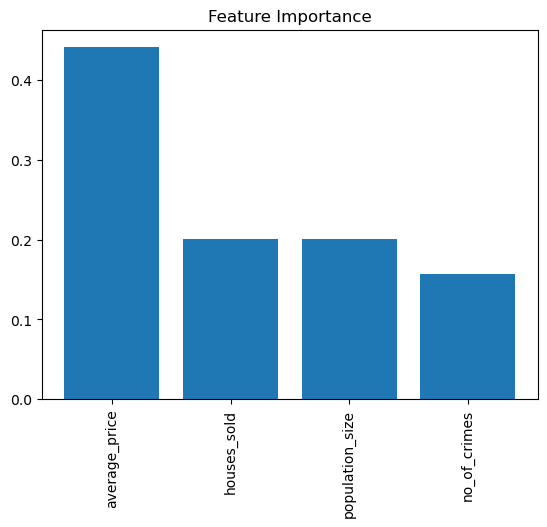

In [8]:
# Feature Importances
importances = best_rf_classifier.feature_importances_
feature_names = features.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.show()

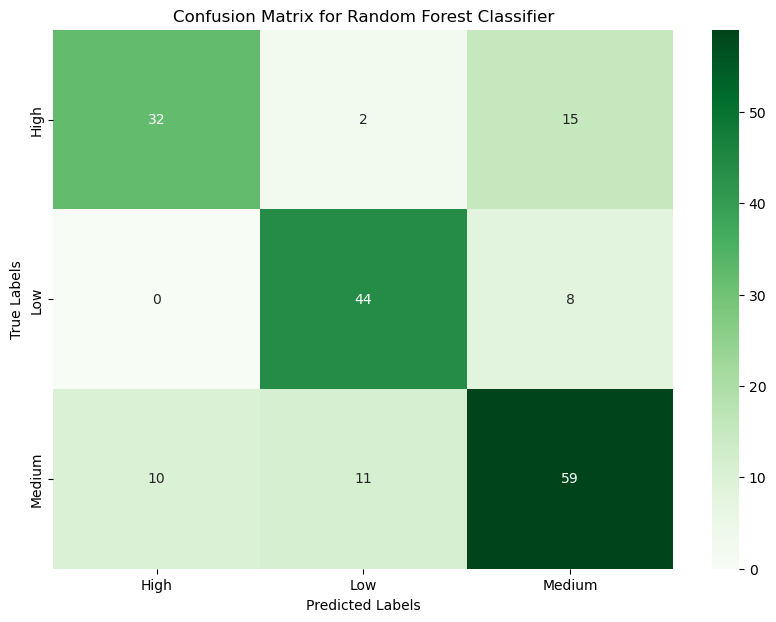

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best_rf, labels=best_rf_classifier.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'] 
}

svm_model = SVC()

svm_grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1)

svm_grid.fit(X_train, y_train)

print("Best parameters found: ", svm_grid.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid.best_score_))

y_pred_svm = svm_grid.best_estimator_.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("SVM Accuracy:", accuracy_svm)
print("SVM Classification Report:\n", report_svm)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.65
SVM Accuracy: 0.7403314917127072
SVM Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.51      0.62        49
         Low       0.83      0.83      0.83        52
      Medium       0.67      0.82      0.74        80

    accuracy                           0.74       181
   macro avg       0.77      0.72      0.73       181
weighted avg       0.75      0.74      0.73       181



In [11]:
###KNN###

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Finding the best n
n_neighbors_range = range(1, 31)
accuracy_scores = []

for n in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train2, y_train2, cv=10, scoring='accuracy')
    accuracy_scores.append(scores.mean())

best_n = n_neighbors_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"The best number of neighbors is {best_n}") 

knn_classifier = KNeighborsClassifier(n_neighbors=9)  

knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print("KNN Accuracy:", accuracy_knn)
print("KNN Classification Report:\n", report_knn)


The best number of neighbors is 9
KNN Accuracy: 0.7182320441988951
KNN Classification Report:
               precision    recall  f1-score   support

        High       0.78      0.63      0.70        49
         Low       0.72      0.83      0.77        52
      Medium       0.69      0.70      0.70        80

    accuracy                           0.72       181
   macro avg       0.73      0.72      0.72       181
weighted avg       0.72      0.72      0.72       181



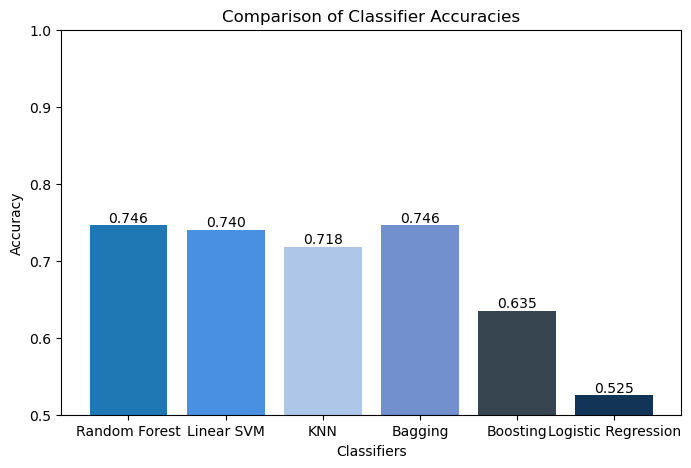

In [12]:
import matplotlib.pyplot as plt

accuracy_rf = 0.7458563535911602  
accuracy_svm = 0.7403314917127072  
accuracy_knn = 0.7182320441988951 
accuracy_bag = 0.746
accuracy_boost = 0.635
accuracy_logreg = 0.525

classifiers = ['Random Forest', 'Linear SVM', 'KNN', 'Bagging','Boosting','Logistic Regression']

accuracies = [accuracy_rf, accuracy_svm, accuracy_knn, accuracy_bag, accuracy_boost, accuracy_logreg]

plt.figure(figsize=(8, 5))
bars = plt.bar(classifiers, accuracies, color=['#1f77b4', '#4a90e2', '#aec7e8','#728fce','#36454f','#123456','#0041c2'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.ylim(0.5, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

plt.show()


In [25]:
###LOGISTIC REGRESSION###


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = merged_data[['average_price', 'houses_sold', 'no_of_crimes', 'population_size']]
y = merged_data['affordability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']  
}

logreg_grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=1)
logreg_grid.fit(X_train, y_train)

print("Best parameters found: ", logreg_grid.best_params_)
print("Best cross-validation score: {:.2f}".format(logreg_grid.best_score_))

y_pred_logreg = logreg_grid.best_estimator_.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))




Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'C': 1, 'solver': 'lbfgs'}
Best cross-validation score: 0.66
Logistic Regression Accuracy: 0.7403314917127072
Logistic Regression Classification Report:
               precision    recall  f1-score   support

        High       0.79      0.53      0.63        49
         Low       0.81      0.85      0.83        52
      Medium       0.68      0.80      0.74        80

    accuracy                           0.74       181
   macro avg       0.76      0.73      0.73       181
weighted avg       0.75      0.74      0.74       181



In [23]:
###BAGGING###

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = merged_data[['average_price', 'houses_sold', 'no_of_crimes', 'population_size']]
y = merged_data['affordability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

bagging_grid = GridSearchCV(BaggingClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
bagging_grid.fit(X_train, y_train)

print("Best parameters found: ", bagging_grid.best_params_)
print("Best cross-validation score: {:.2f}".format(bagging_grid.best_score_))

y_pred_bagging = bagging_grid.best_estimator_.predict(X_test)

print("Bagging Classifier Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("Bagging Classifier Classification Report:\n", classification_report(y_test, y_pred_bagging))




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Best cross-validation score: 0.75
Bagging Classifier Accuracy: 0.7458563535911602
Bagging Classifier Classification Report:
               precision    recall  f1-score   support

        High       0.72      0.69      0.71        49
         Low       0.80      0.85      0.82        52
      Medium       0.72      0.71      0.72        80

    accuracy                           0.75       181
   macro avg       0.75      0.75      0.75       181
weighted avg       0.74      0.75      0.74       181



In [24]:
###ADABOOST###

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = merged_data[['average_price', 'houses_sold', 'no_of_crimes', 'population_size']]
y = merged_data['affordability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

ada_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)), param_grid, cv=5, scoring='accuracy', verbose=1)
ada_grid.fit(X_train, y_train)

print("Best parameters found: ", ada_grid.best_params_)
print("Best cross-validation score: {:.2f}".format(ada_grid.best_score_))

y_pred_ada = ada_grid.best_estimator_.predict(X_test)

print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ada))
print("AdaBoost Classification Report:\n", classification_report(y_test, y_pred_ada))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation score: 0.69
AdaBoost Accuracy: 0.7071823204419889
AdaBoost Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.51      0.62        49
         Low       0.77      0.77      0.77        52
      Medium       0.64      0.79      0.71        80

    accuracy                           0.71       181
   macro avg       0.74      0.69      0.70       181
weighted avg       0.72      0.71      0.70       181



In [22]:
###NAIVE BAYES###

import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = merged_data[['average_price', 'houses_sold', 'no_of_crimes', 'population_size']]
y = merged_data['affordability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]}

nb_grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy', verbose=1)
nb_grid.fit(X_train, y_train)

print("Best parameters found: ", nb_grid.best_params_)
print("Best cross-validation score: {:.2f}".format(nb_grid.best_score_))

y_pred_nb = nb_grid.best_estimator_.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'var_smoothing': 1e-09}
Best cross-validation score: 0.53
Naive Bayes Accuracy: 0.48066298342541436
Naive Bayes Classification Report:
               precision    recall  f1-score   support

        High       0.37      0.84      0.52        49
         Low       0.69      0.79      0.74        52
      Medium       0.42      0.06      0.11        80

    accuracy                           0.48       181
   macro avg       0.49      0.56      0.45       181
weighted avg       0.48      0.48      0.40       181

